In [1]:
import os
os.getcwd()
data_path = os.path.join(os.getcwd(), '/kaggle/input/double-mnist/double_mnist')

print(data_path)

/kaggle/input/double-mnist/double_mnist


### 2.1 Data Loading and Preprocessing

In [2]:
import cv2

data_path = os.path.join(os.getcwd(), '/kaggle/input/double_mnist')

print(os.listdir('/kaggle/input/double_mnist'))

def load_mnist_data(data_path):
    def load_images_from_folder(folder):
        images = []
        labels = []
        for foldername in sorted(os.listdir(folder)):
            subfolder_path = os.path.join(folder, foldername)
            for filename in sorted(os.listdir(subfolder_path)):
                if filename.endswith('.png'):
                    file_path = os.path.join(subfolder_path, filename)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    images.append(img)
                    if(foldername != '0'):
                        labels.append(len(foldername))
                    else:
                        labels.append(0)
        return images, labels

    train_images, train_labels = load_images_from_folder(os.path.join(data_path, 'train'))
    val_images, val_labels = load_images_from_folder(os.path.join(data_path, 'val'))
    test_images, test_labels = load_images_from_folder(os.path.join(data_path, 'test'))

    train_data = list(zip(train_images, train_labels))
    val_data = list(zip(val_images, val_labels))
    test_data = list(zip(test_images, test_labels))
    
    return train_data, val_data, test_data

train_data, val_data, test_data = load_mnist_data(data_path)

print(f"Train set size: {len(train_data)} images")
print(f"Validation set size: {len(val_data)} images")
print(f"Test set size: {len(test_data)} images")


['val', 'test', 'train']
Train set size: 12600 images
Validation set size: 3000 images
Test set size: 4600 images


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch

class MNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform if transform is not None else self.default_transform()
    
    def default_transform(self):
        return transforms.Compose([
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        
        image = torch.FloatTensor(image).unsqueeze(0) / 255.0
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

def create_dataloaders(data_path, batch_size=32, num_workers=4):

    train_data, val_data, test_data = load_mnist_data(data_path)
    
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    train_dataset = MNISTDataset(train_data, transform=transform)
    val_dataset = MNISTDataset(val_data, transform=transform)
    test_dataset = MNISTDataset(test_data, transform=transform)
    
      
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader, test_loader

def create_dataloaders(data_path, batch_size=32, num_workers=4):

    train_data, val_data, test_data = load_mnist_data(data_path)
    
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    # Create datasets
    train_dataset = MNISTDataset(train_data, transform=transform)
    val_dataset = MNISTDataset(val_data, transform=transform)
    test_dataset = MNISTDataset(test_data, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, val_loader, test_loader

if __name__ == "__main__":
    data_path = os.path.join(os.getcwd(), '/kaggle/input/double_mnist')
    
    train_loader, val_loader, test_loader = create_dataloaders(
        data_path,
        batch_size=32,
        num_workers=4
    )
    
    print(f"\nDataset sizes:")
    print(f"Train loader: {len(train_loader.dataset)} images, {len(train_loader)} batches")
    print(f"Validation loader: {len(val_loader.dataset)} images, {len(val_loader)} batches")
    print(f"Test loader: {len(test_loader.dataset)} images, {len(test_loader)} batches")
    
    for images, labels in train_loader:
#         print(images[0])
        print(f"\nBatch shapes:")
        print(f"Images: {images.shape}")
        print(f"Labels: {labels.shape}") 
        break
        
    


Dataset sizes:
Train loader: 12600 images, 394 batches
Validation loader: 3000 images, 94 batches
Test loader: 4600 images, 144 batches

Batch shapes:
Images: torch.Size([32, 1, 128, 128])
Labels: torch.Size([32])


### 2.2 Implement the CNN Class

In [ ]:
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self, task, num_classes, learning_rate, dropout_rate, num_conv_layers, optimizer_name):
        super(CNN, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.num_conv_layers = num_conv_layers
        self.optimizer_name = optimizer_name  

        self.current_size = 128
        
        layers = []
        in_channels = 1  
        out_channels = 32
        
        for _ in range(num_conv_layers):
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout_rate)
            ]

            in_channels = out_channels
            out_channels *= 2

            self.current_size = self.current_size // 2
            
        self.conv = nn.Sequential(*layers)
        

        self.flat_features = in_channels * (self.current_size ** 2)

#         print(f"Number of conv layers: {num_conv_layers}")
#         print(f"Final feature map size: {self.current_size}x{self.current_size}")
#         print(f"Number of channels: {in_channels}")
#         print(f"Flattened features: {self.flat_features}")

        if self.task == 'classification':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
        elif self.task == 'regression':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 1)
            )
        else:
            raise ValueError("Enter correct brother...")

    def forward(self, x):

        x = self.conv(x)

        x = x.view(x.size(0), -1)  # Flatten
        
        return self.fc(x)

    def compile_model(self, optimizer_name):
        if optimizer_name == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Optimizer not supported")

    def train_model(self, train_loader, val_loader, num_epochs, device):
        if self.task == 'classification':
            criterion = nn.CrossEntropyLoss()
            label_type = torch.long
        elif self.task == 'regression':
            criterion = nn.MSELoss()
            label_type = torch.float

        optimizer = self.compile_model(optimizer_name=self.optimizer_name)
        self.to(device)

        train_losses, val_losses = [], []
        final_train_accuracy = 0.0
        final_val_accuracy = 0.0
        final_validation_loss = float('inf')
        final_training_loss = float('inf')

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device, dtype=label_type)
                
                # Print shapes for first batch of first epoch
#                 if epoch == 0 and batch_idx == 0:
#                     print(f"Training batch shapes - Images: {images.shape}, Labels: {labels.shape}")
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            # Validation phase
            self.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device, dtype=label_type)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()

            # Average losses
            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            final_training_loss = avg_train_loss
            final_validation_loss = avg_val_loss

            # Calculate train and validation accuracy
            train_metrics = self.evaluate_metrics(train_loader, device)
            val_metrics = self.evaluate_metrics(val_loader, device)

            final_train_accuracy = train_metrics['accuracy']
            final_val_accuracy = val_metrics['accuracy']

        # Final accuracy after all epochs
        test_metrics = self.evaluate_metrics(val_loader, device)
        final_accuracy = test_metrics['accuracy']

        return (final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy)

    def evaluate_metrics(self, data_loader, device):
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                
                _, predictions = torch.max(outputs, 1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)

        return {
            'accuracy': accuracy,
        }

In [5]:
import torch
import wandb
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(
    task='classification',
    num_classes=10,  
    learning_rate=0.001,  
    dropout_rate=0.2,
    num_conv_layers=3,
    optimizer_name='adam'
)

final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy = model.train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5, 
    device=device
)

# predictions, actual = model.predict(test_loader, device)

Epoch [1/5], Train Loss: 0.1798, Val Loss: 0.0019
Epoch [2/5], Train Loss: 0.0148, Val Loss: 0.0045
Epoch [3/5], Train Loss: 0.0203, Val Loss: 0.0066
Epoch [4/5], Train Loss: 0.0156, Val Loss: 0.0001
Epoch [5/5], Train Loss: 0.0010, Val Loss: 0.0003


In [6]:
print(final_validation_loss)
print(final_training_loss)
print(final_train_accuracy)
print(final_val_accuracy)
print(final_accuracy)

0.0002882281261597425
0.000990843973008024
1.0
0.9996666666666667
0.9996666666666667


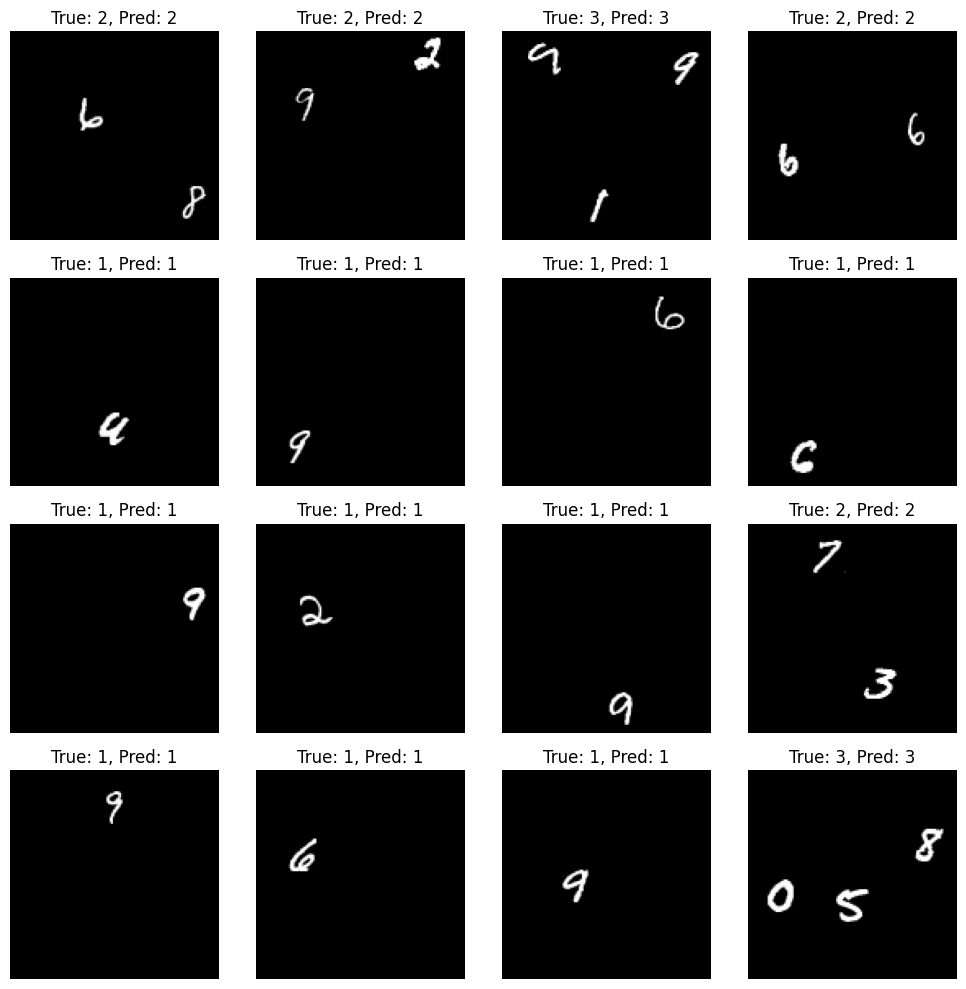

1.0


In [7]:
import matplotlib.pyplot as plt

def show_predictions(model, data_loader, device, num_images=16):
    model.eval()
    images_shown = 0
    fig, axs = plt.subplots(int(num_images**0.5), int(num_images**0.5), figsize=(10, 10))
    axs = axs.flatten()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # Loop through the batch
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                img = images[i].cpu().squeeze()  # Convert image to CPU and remove batch dimension
                true_label = labels[i].item()
                pred_label = predictions[i].item()
                
                axs[images_shown].imshow(img, cmap="gray")
                axs[images_shown].set_title(f"True: {true_label}, Pred: {pred_label}")
                axs[images_shown].axis('off')
                
                images_shown += 1
            
            if images_shown >= num_images:
                break
                
    plt.tight_layout()
    plt.show()

def accuracy(model, data_loader, device):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            for i in range(images.size(0)):

                
                img = images[i].cpu().squeeze()  # Convert image to CPU and remove batch dimension
                true_label = labels[i].item()
                pred_label = predictions[i].item()
                if true_label == pred_label:
                    accuracy = accuracy + 1
                    
    return accuracy/len(data_loader.dataset)


show_predictions(model, test_loader, device, num_images=16)

print(accuracy(model, test_loader, device))

### 2.3 Hyperparameter Tuning

The best model from the tuning of classification is as follows:
num_conv_layers = 2,learning_rate = 0.001,dropout=0.5,num_epochs=15,adam optimizer

The best model from the tuning of regression is as follows:
num_conv_layers = 3,learning_rate = 0.0001,dropout=0.2,num_epochs=10,adam optimizer

regressor doesnt perform well with high dropout rate.

Below are the tuning results for classification
![image6](figures/image6.png)
![temp](figures/image%20copy.png)
![temp](figures/image%20copy.png)
![temp](figures/image%20copy%203.png)
![temp](figures/image%20copy%204.png)
![temp](figures/image%20copy%205.png)
Below are the tuning results for regression from wandb and the train and validation loss plots are logged into wandb
![image.png](figures/image%20copy%206.png)

In [8]:
# import wandb
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()

# my_secret = user_secrets.get_secret("wandb_api_key") 

# wandb.login(key=my_secret)

In [9]:
# import torch
# import wandb
# import torch.nn.functional as F
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# import matplotlib.pyplot as plt

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# wandb.init(project="temp", config={
#     "learning_rate": 0.001,
#     "num_epochs": 3,
#     "num_classes": 10,
#     "dropout_rate": 0.2,
#     "num_conv_layers": 3,
#     "optimizer": 'adam'
# })

# model = CNN(
#     task='classification',
#     num_classes=10,  
#     learning_rate=0.001,  
#     dropout_rate=0.2,
#     num_conv_layers=3,
#     optimizer_name='adam'
# )

# final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy = model.train_model(
#     train_loader=train_loader,
#     val_loader=val_loader,
#     num_epochs=3, 
#     device=device
# )

# wandb.log({
#     "final_validation_loss": final_validation_loss,
#     "final_training_loss": final_training_loss,
#     "final_train_accuracy": final_train_accuracy,
#     "final_val_accuracy": final_val_accuracy,
#     "final_accuracy": final_accuracy
# })

# wandb.finish()


In [10]:
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self, task, num_classes, learning_rate, dropout_rate, num_conv_layers, optimizer_name):
        super(CNN, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.num_conv_layers = num_conv_layers
        self.optimizer_name = optimizer_name 

        self.current_size = 128
        
        layers = []
        in_channels = 1  
        out_channels = 32
        
        for _ in range(num_conv_layers):
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout_rate)
            ]

            in_channels = out_channels
            out_channels *= 2

            self.current_size = self.current_size // 2
            
        self.conv = nn.Sequential(*layers)
        
        self.flat_features = in_channels * (self.current_size ** 2)

        # Print network info for debugging
#         print(f"Number of conv layers: {num_conv_layers}")
#         print(f"Final feature map size: {self.current_size}x{self.current_size}")
#         print(f"Number of channels: {in_channels}")
#         print(f"Flattened features: {self.flat_features}")

        if self.task == 'classification':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
        elif self.task == 'regression':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 1)
            )
        else:
            raise ValueError("Enter correct task...")

    def forward(self, x):
        # Print shape for debugging
#         if self.training and torch.rand(1).item() < 0.01:  # Print occasionally during training
#             print(f"Input shape: {x.shape}")
        
        x = self.conv(x)
#         if self.training and torch.rand(1).item() < 0.01:  # Print occasionally during training
#             print(f"After conv shape: {x.shape}")
        
        x = x.view(x.size(0), -1)  # Flatten
#         if self.training and torch.rand(1).item() < 0.01:  # Print occasionally during training
#             print(f"Flattened shape: {x.shape}")
        
        return self.fc(x)

    def compile_model(self, optimizer_name):
        if optimizer_name == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Optimizer not supported")

    def train_model(self, train_loader, val_loader, num_epochs, device):
        if self.task == 'classification':
            criterion = nn.CrossEntropyLoss()
            label_type = torch.long
        elif self.task == 'regression':
            criterion = nn.MSELoss()
            label_type = torch.float

        optimizer = self.compile_model(optimizer_name=self.optimizer_name)
        self.to(device)

        train_losses, val_losses = [], []
        final_train_accuracy = 0.0
        final_val_accuracy = 0.0
        final_validation_loss = float('inf')
        final_training_loss = float('inf')

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device, dtype=label_type)
                
                # Print shapes for first batch of first epoch
#                 if epoch == 0 and batch_idx == 0:
#                     print(f"Training batch shapes - Images: {images.shape}, Labels: {labels.shape}")
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            # Validation phase
            self.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device, dtype=label_type)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()

            # Average losses
            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            final_training_loss = avg_train_loss
            final_validation_loss = avg_val_loss

            # Calculate train and validation accuracy
            train_metrics = self.evaluate_metrics(train_loader, device)
            val_metrics = self.evaluate_metrics(val_loader, device)

            final_train_accuracy = train_metrics['accuracy']
            final_val_accuracy = val_metrics['accuracy']
            
            wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "epoch": epoch + 1,
            })

        # Final accuracy after all epochs
        test_metrics = self.evaluate_metrics(val_loader, device)
        final_accuracy = test_metrics['accuracy']

        return (final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy)

    def evaluate_metrics(self, data_loader, device):
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                
                _, predictions = torch.max(outputs, 1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)

        return {
            'accuracy': accuracy,
        }

In [11]:
# import torch
# import wandb
# import torch.nn.functional as F
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# import matplotlib.pyplot as plt

# # Define sweep configuration 
# sweep_config = {
#     'method': 'grid',  # Grid search across all combinations
#     'name': 'cnn-sweep',
#     'metric': {
#         'name': 'val_accuracy',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'learning_rate': {
#             'values': [0.001, 0.0001]
#         },
#         'num_epochs': {
#             'values': [5, 10, 15]
#         },
#         'dropout_rate': {
#             'values': [0.2, 0.5]
#         },
#         'num_conv_layers': {
#             'values': [2, 3]
#         },
#         'optimizer': {
#             'values': ['adam', 'sgd']
#         }
#     }
# }

# def train_sweep():
#     wandb.init()
    
#     config = wandb.config
    
#     model = CNN(
#         task='classification',
#         num_classes=10,
#         learning_rate=config.learning_rate,
#         dropout_rate=config.dropout_rate,
#         num_conv_layers=config.num_conv_layers,
#         optimizer_name=config.optimizer
#     )
    
#     model_params = {
#         "total_params": sum(p.numel() for p in model.parameters()),
#         "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
#     }
    
#     for name, param in model.named_parameters():
#         model_params[f"param_size/{name}"] = param.numel()
#         if param.requires_grad:
#             model_params[f"param_norm/{name}"] = torch.norm(param).item()
    
#     wandb.run.summary.update({
#         "model_architecture": str(model),
#         **model_params
#     })
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#     final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy = model.train_model(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         num_epochs=config.num_epochs,
#         device=device
#     )
    
#     wandb.log({

#         "final_validation_loss": final_validation_loss,
#         "final_training_loss": final_training_loss,
#         "final_train_accuracy": final_train_accuracy,
#         "final_val_accuracy": final_val_accuracy,
#         "final_accuracy": final_accuracy,
        
#         "learning_rate": config.learning_rate,
#         "num_epochs": config.num_epochs,
#         "dropout_rate": config.dropout_rate,
#         "num_conv_layers": config.num_conv_layers,
#         "optimizer": config.optimizer,
        
#         "device": str(device),
#     })

#     gradient_stats = {}
#     for name, param in model.named_parameters():
#         if param.grad is not None:
#             gradient_stats[f"final_gradient_norm/{name}"] = torch.norm(param.grad).item()
    
#     wandb.log(gradient_stats)

# sweep_id = wandb.sweep(sweep_config, project="CNN-Classification")

# wandb.agent(sweep_id, train_sweep, count=48)

### 2.4 Feature Maps

Epoch [1/10], Train Loss: 0.1928, Val Loss: 0.0060
Epoch [2/10], Train Loss: 0.0174, Val Loss: 0.0054
Epoch [3/10], Train Loss: 0.0084, Val Loss: 0.0017
Epoch [4/10], Train Loss: 0.0161, Val Loss: 0.0026
Epoch [5/10], Train Loss: 0.0157, Val Loss: 0.0612
Epoch [6/10], Train Loss: 0.0285, Val Loss: 0.0004
Epoch [7/10], Train Loss: 0.0146, Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0164, Val Loss: 0.0009
Epoch [9/10], Train Loss: 0.0042, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0175, Val Loss: 0.0000


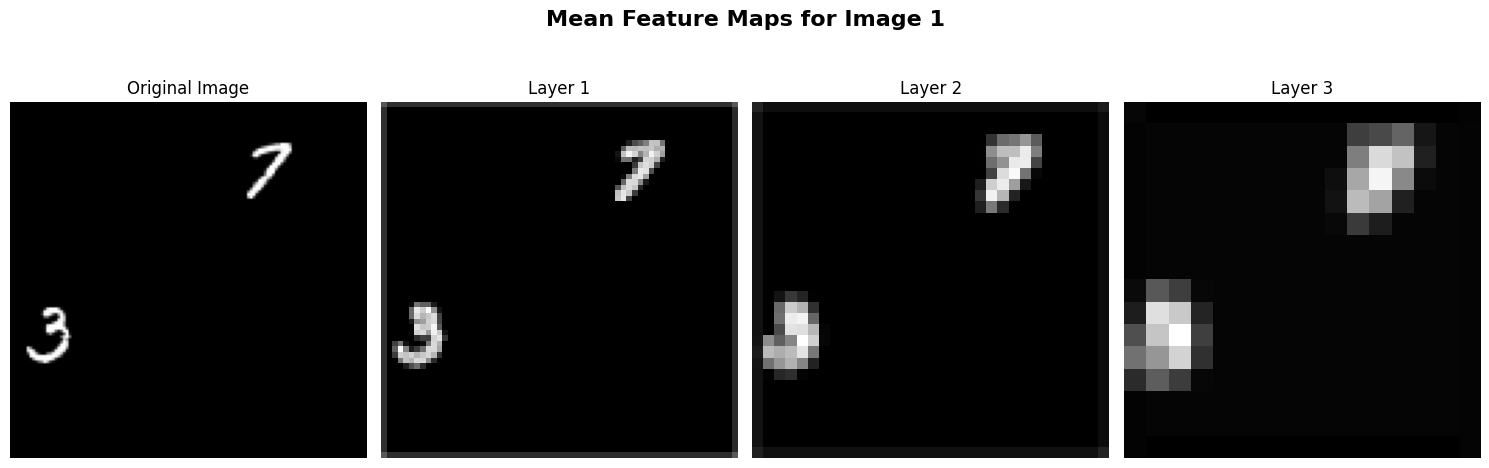

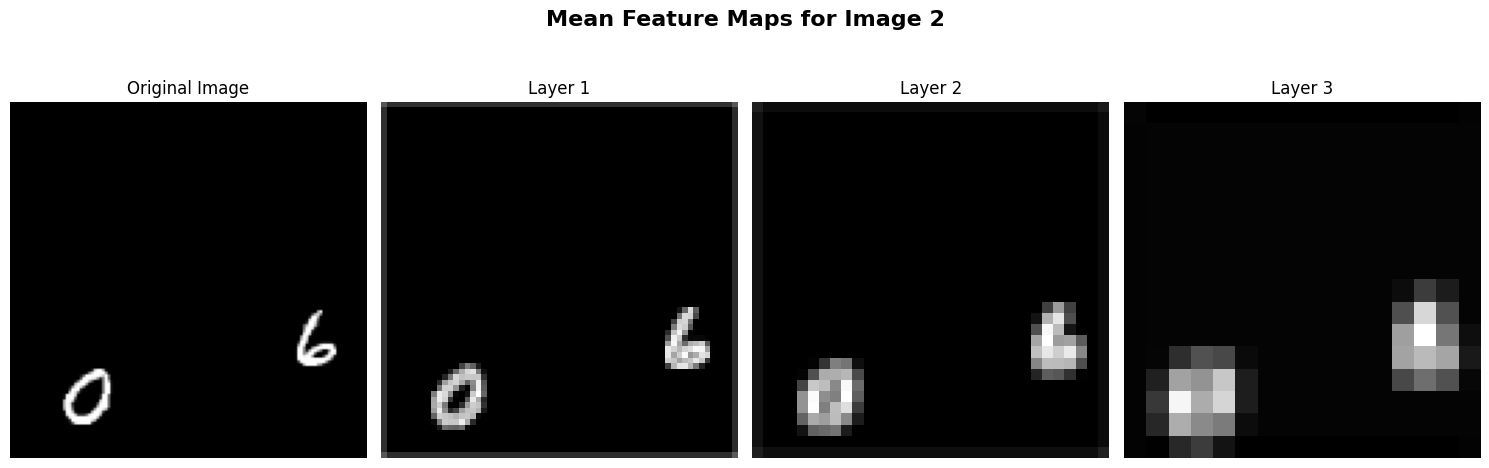

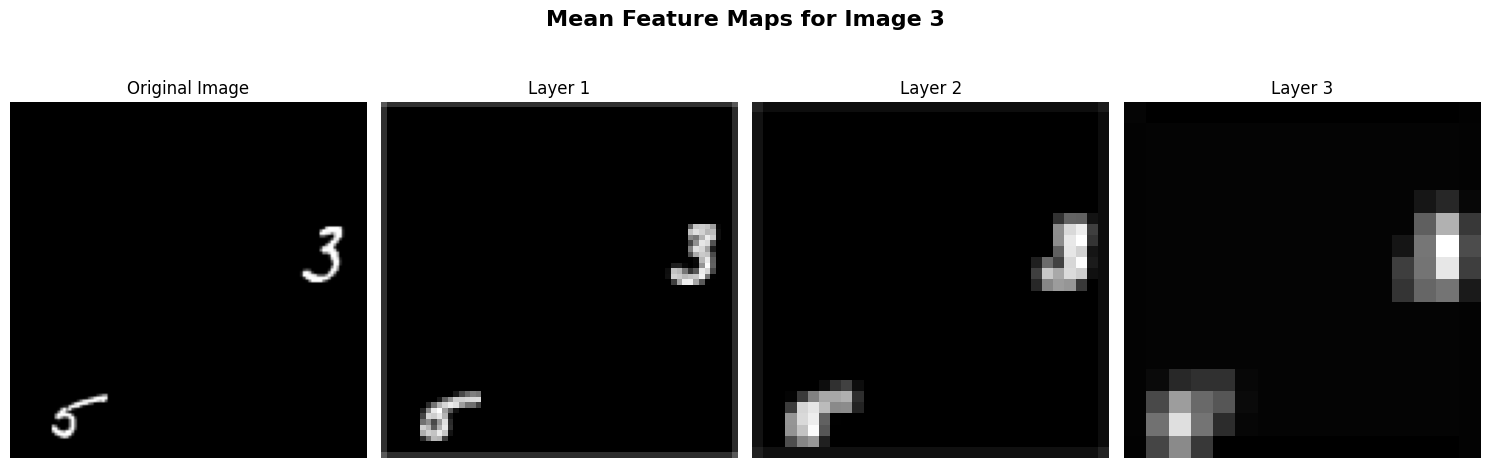


Layer 1 Analysis:
Mean activation: 0.2415
Max activation: 18.2869
Sparsity (fraction of zero activations): 0.4440

Layer 2 Analysis:
Mean activation: 0.2908
Max activation: 15.8751
Sparsity (fraction of zero activations): 0.6019

Layer 3 Analysis:
Mean activation: 0.2563
Max activation: 9.9740
Sparsity (fraction of zero activations): 0.4542


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self, task, num_classes, learning_rate, dropout_rate, num_conv_layers, optimizer_name):
        super(CNN, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.num_conv_layers = num_conv_layers
        self.optimizer_name = optimizer_name
        
        self.current_size = 128
        
        # Store each conv block separately to access intermediate outputs
        self.conv_blocks = nn.ModuleList()
        in_channels = 1
        out_channels = 32
        
        for _ in range(num_conv_layers):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout_rate)
            )
            self.conv_blocks.append(block)
            
            in_channels = out_channels
            out_channels *= 2
            self.current_size = self.current_size // 2

        self.flat_features = in_channels * (self.current_size ** 2)

        if self.task == 'classification':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
        elif self.task == 'regression':
            self.fc = nn.Sequential(
                nn.Linear(self.flat_features, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 1)
            )
        else:
            raise ValueError("Enter correct brother...")

    def forward(self, x, return_feature_maps=False):
        feature_maps = []
        
        # Pass through each conv block and store intermediate outputs
        for block in self.conv_blocks:
            x = block(x)
            if return_feature_maps:
                feature_maps.append(x.detach().clone())
        
        x = x.view(x.size(0), -1)  # Flatten
        output = self.fc(x)
        
        if return_feature_maps:
            return output, feature_maps
        return output

    def compile_model(self, optimizer_name):
        if optimizer_name == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Optimizer not supported")

    def train_model(self, train_loader, val_loader, num_epochs, device):
        if self.task == 'classification':
            criterion = nn.CrossEntropyLoss()
            label_type = torch.long
        elif self.task == 'regression':
            criterion = nn.MSELoss()
            label_type = torch.float

        optimizer = self.compile_model(optimizer_name=self.optimizer_name)
        self.to(device)

        train_losses, val_losses = [], []
        final_train_accuracy = 0.0
        final_val_accuracy = 0.0
        final_validation_loss = float('inf')
        final_training_loss = float('inf')

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device, dtype=label_type)
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            self.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device, dtype=label_type)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            final_training_loss = avg_train_loss
            final_validation_loss = avg_val_loss

            train_metrics = self.evaluate_metrics(train_loader, device)
            val_metrics = self.evaluate_metrics(val_loader, device)

            final_train_accuracy = train_metrics['accuracy']
            final_val_accuracy = val_metrics['accuracy']

        test_metrics = self.evaluate_metrics(val_loader, device)
        final_accuracy = test_metrics['accuracy']

        return (final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy)

    def evaluate_metrics(self, data_loader, device):
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                
                _, predictions = torch.max(outputs, 1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)

        return {
            'accuracy': accuracy,
        }

def visualize_feature_maps(model, images, num_images=3):
    """
    Visualize the mean feature maps across channels for specified number of images in a single row
    
    Args:
        model: The CNN model
        images: Batch of images (B, C, H, W)
        num_images: Number of images to visualize
    """
    model.eval()
    with torch.no_grad():
        # Get feature maps for the first num_images
        _, feature_maps = model(images[:num_images], return_feature_maps=True)
        
        for img_idx in range(num_images):
            fig, axes = plt.subplots(1, len(feature_maps) + 1, figsize=(15, 5))
            fig.suptitle(f'Mean Feature Maps for Image {img_idx + 1}', fontsize=16, weight='bold')
            
            # Display original image in the first column
            axes[0].imshow(images[img_idx][0].cpu(), cmap='gray')
            axes[0].set_title('Original Image', fontsize=12)
            axes[0].axis('off')
            
            # Display mean feature maps for each layer in the same row
            for layer_idx, feature_map in enumerate(feature_maps):
                # Compute mean across channels
                mean_feature_map = feature_map[img_idx].mean(dim=0).cpu()
                
                axes[layer_idx + 1].imshow(mean_feature_map, cmap='gray')
                axes[layer_idx + 1].set_title(f'Layer {layer_idx + 1}', fontsize=12)
                axes[layer_idx + 1].axis('off')
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()


def analyze_feature_maps(feature_maps, layer_idx):
    """
    Analyze characteristics of feature maps at different layers
    
    Args:
        feature_maps: List of feature maps from different layers
        layer_idx: Index of the layer to analyze
    """
    feature_map = feature_maps[layer_idx]
    
    # Calculate statistics
    mean_activation = torch.mean(feature_map).item()
    max_activation = torch.max(feature_map).item()
    sparsity = (feature_map == 0).float().mean().item()
    
    print(f"\nLayer {layer_idx + 1} Analysis:")
    print(f"Mean activation: {mean_activation:.4f}")
    print(f"Max activation: {max_activation:.4f}")
    print(f"Sparsity (fraction of zero activations): {sparsity:.4f}")


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = CNN(
    task='classification',
    num_classes=10,
    learning_rate=0.001,
    dropout_rate=0.2,
    num_conv_layers=3,
    optimizer_name='adam'
)

# Train model
final_validation_loss, final_training_loss, final_train_accuracy, final_val_accuracy, final_accuracy = model.train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    device=device
)

images, _ = next(iter(train_loader))
images = images.to(device)
 
visualize_feature_maps(model, images, num_images=3)

_, feature_maps = model(images, return_feature_maps=True)
for i in range(len(feature_maps)):
    analyze_feature_maps(feature_maps, i)

This feature map makes sense as we want to learn the number of digits in the image the shape of the digit is irrelavant is basically being blurred out

### Tuning for regression code and final code with classification + regression

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class CNN_Regression(nn.Module):
    def __init__(self, task, num_classes, learning_rate, dropout_rate, num_conv_layers, optimizer_name):
        super(CNN_Regression, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.num_conv_layers = num_conv_layers
        self.optimizer_name = optimizer_name
        self.current_size = 128
        
        self.conv_blocks = nn.ModuleList()
        in_channels = 1
        out_channels = 32
        
        for _ in range(num_conv_layers):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.conv_blocks.append(block)

            in_channels = out_channels
            out_channels *= 2
            self.current_size //= 2

        self.flat_features = in_channels * (self.current_size ** 2)

        self.fc = nn.Sequential(
            nn.Linear(self.flat_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x, return_feature_maps=False):
        feature_maps = []
        
        for block in self.conv_blocks:
            x = block(x)
            if return_feature_maps:
                feature_maps.append(x.detach().clone())
        
        x = x.view(x.size(0), -1)  
        output = self.fc(x)
        
        if return_feature_maps:
            return output, feature_maps
        return output

    def evaluate_metrics(self, data_loader, device):
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                
                # Round predictions to nearest integer for classification
                rounded_preds = torch.round(outputs).clamp(0, 9).long()  # Clamp between 0-9 for Fashion MNIST
                
                all_preds.extend(rounded_preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate classification accuracy using rounded predictions
        accuracy = accuracy_score(all_labels, np.array(all_preds).flatten())
        
        return {
            'accuracy': accuracy,
        }

    def train_model(self, train_loader, val_loader, test_loader, num_epochs, device):
        criterion = nn.MSELoss()
        optimizer = self.compile_model(optimizer_name=self.optimizer_name)
        self.to(device)

        train_losses, val_losses = [], []
        best_val_accuracy = 0.0

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            self.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device).float().view(-1, 1)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)
            
            train_metrics = self.evaluate_metrics(train_loader, device)
            val_metrics = self.evaluate_metrics(val_loader, device)
            
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_metrics["accuracy"]:.4f}')
#             print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_metrics["accuracy"]:.4f}')
#             print('-' * 50)

            if val_metrics['accuracy'] > best_val_accuracy:
                best_val_accuracy = val_metrics['accuracy']

        # Final evaluation on test set
        final_train_metrics = self.evaluate_metrics(train_loader, device)
        final_val_metrics = self.evaluate_metrics(val_loader, device)
        final_test_metrics = self.evaluate_metrics(test_loader, device)

        return {
            'final_train_loss': avg_train_loss,
            'final_val_loss': avg_val_loss,
            'final_train_accuracy': final_train_metrics['accuracy'],
            'final_val_accuracy': final_val_metrics['accuracy'],
            'final_test_accuracy': final_test_metrics['accuracy']
        }

    def compile_model(self, optimizer_name):
        if optimizer_name == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)

        
import matplotlib.pyplot as plt

def visualize_feature_maps(model, images, num_images=3):
    """
    Visualize the mean feature maps across channels for specified number of images in a single row
    
    Args:
        model: The CNN model
        images: Batch of images (B, C, H, W)
        num_images: Number of images to visualize
    """
    model.eval()
    with torch.no_grad():
        # Get feature maps for the first num_images
        _, feature_maps = model(images[:num_images], return_feature_maps=True)
        
        for img_idx in range(num_images):
            fig, axes = plt.subplots(1, len(feature_maps) + 1, figsize=(15, 5))
            fig.suptitle(f'Mean Feature Maps for Image {img_idx + 1}', fontsize=16, weight='bold')
            
            # Display original image in the first column
            axes[0].imshow(images[img_idx][0].cpu(), cmap='gray')
            axes[0].set_title('Original Image', fontsize=12)
            axes[0].axis('off')
            
            # Display mean feature maps for each layer in the same row
            for layer_idx, feature_map in enumerate(feature_maps):
                # Compute mean across channels
                mean_feature_map = feature_map[img_idx].mean(dim=0).cpu()
                
                axes[layer_idx + 1].imshow(mean_feature_map, cmap='gray')
                axes[layer_idx + 1].set_title(f'Layer {layer_idx + 1}', fontsize=12)
                axes[layer_idx + 1].axis('off')
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()

def analyze_feature_maps(feature_maps, layer_idx):
    """
    Analyze characteristics of feature maps at different layers
    
    Args:
        feature_maps: List of feature maps from different layers
        layer_idx: Index of the layer to analyze
    """
    feature_map = feature_maps[layer_idx]
    
    # Calculate statistics
    mean_activation = torch.mean(feature_map).item()
    max_activation = torch.max(feature_map).item()
    sparsity = (feature_map == 0).float().mean().item()
    
    print(f"\nLayer {layer_idx + 1} Analysis:")
    print(f"Mean activation: {mean_activation:.4f}")
    print(f"Max activation: {max_activation:.4f}")
    print(f"Sparsity (fraction of zero activations): {sparsity:.4f}")

        
model = CNN_Regression(
    task='regression',
    num_classes=10,  # Fashion MNIST has 10 classes
    learning_rate=0.001,
    dropout_rate=0.2,
    num_conv_layers=3,
    optimizer_name='adam'
)

# Train model
metrics = model.train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=5,
    device=device
)

print("Final Metrics:")
print(f"Training Loss: {metrics['final_train_loss']:.4f}")
print(f"Validation Loss: {metrics['final_val_loss']:.4f}")
print(f"Training Accuracy: {metrics['final_train_accuracy']:.4f}")
print(f"Validation Accuracy: {metrics['final_val_accuracy']:.4f}")
print(f"Test Accuracy: {metrics['final_test_accuracy']:.4f}")

Epoch [1/5]
Train Loss: 0.1433, Train Accuracy: 0.9995
Epoch [2/5]
Train Loss: 0.0463, Train Accuracy: 0.9998
Epoch [3/5]
Train Loss: 0.0449, Train Accuracy: 0.9860
Epoch [4/5]
Train Loss: 0.0398, Train Accuracy: 1.0000
Epoch [5/5]
Train Loss: 0.0376, Train Accuracy: 1.0000
Final Metrics:
Training Loss: 0.0376
Validation Loss: 0.0085
Training Accuracy: 1.0000
Validation Accuracy: 0.9997
Test Accuracy: 1.0000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class CNN_Regression(nn.Module):
    def __init__(self, task, num_classes, learning_rate, dropout_rate, num_conv_layers, optimizer_name):
        super(CNN_Regression, self).__init__()
        self.task = task
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.num_conv_layers = num_conv_layers
        self.optimizer_name = optimizer_name
        self.current_size = 128
        
        self.conv_blocks = nn.ModuleList()
        in_channels = 1
        out_channels = 32
        
        for _ in range(num_conv_layers):
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.conv_blocks.append(block)

            in_channels = out_channels
            out_channels *= 2
            self.current_size //= 2

        self.flat_features = in_channels * (self.current_size ** 2)

        self.fc = nn.Sequential(
            nn.Linear(self.flat_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x, return_feature_maps=False):
        feature_maps = []
        
        for block in self.conv_blocks:
            x = block(x)
            if return_feature_maps:
                feature_maps.append(x.detach().clone())
        
        x = x.view(x.size(0), -1)  
        output = self.fc(x)
        
        if return_feature_maps:
            return output, feature_maps
        return output

    def evaluate_metrics(self, data_loader, device):
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                
                # Round predictions to nearest integer for classification
                rounded_preds = torch.round(outputs).clamp(0, 9).long()  # Clamp between 0-9 for Fashion MNIST
                
                all_preds.extend(rounded_preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate classification accuracy using rounded predictions
        accuracy = accuracy_score(all_labels, np.array(all_preds).flatten())
        
        return {
            'accuracy': accuracy,
        }

    def train_model(self, train_loader, val_loader, test_loader, num_epochs, device):
        criterion = nn.MSELoss()
        optimizer = self.compile_model(optimizer_name=self.optimizer_name)
        self.to(device)

        train_losses, val_losses = [], []
        best_val_accuracy = 0.0

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            self.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device).float().view(-1, 1)
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)

            train_metrics = self.evaluate_metrics(train_loader, device)
            val_metrics = self.evaluate_metrics(val_loader, device)
            
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_metrics["accuracy"]:.4f}')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_metrics["accuracy"]:.4f}')
            print('-' * 50)

            # Log training and validation metrics to WandB
            wandb.log({
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "train_accuracy": train_metrics["accuracy"],
                "val_accuracy": val_metrics["accuracy"],
                "epoch": epoch + 1,
            })
            
            if val_metrics['accuracy'] > best_val_accuracy:
                best_val_accuracy = val_metrics['accuracy']

        # Final evaluation on test set
        final_train_metrics = self.evaluate_metrics(train_loader, device)
        final_val_metrics = self.evaluate_metrics(val_loader, device)
        final_test_metrics = self.evaluate_metrics(test_loader, device)

        return {
            'final_train_loss': avg_train_loss,
            'final_val_loss': avg_val_loss,
            'final_train_accuracy': final_train_metrics['accuracy'],
            'final_val_accuracy': final_val_metrics['accuracy'],
            'final_test_accuracy': final_test_metrics['accuracy']
        }

    def compile_model(self, optimizer_name):
        if optimizer_name == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif optimizer_name == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)

In [15]:
# import wandb
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()

# my_secret = user_secrets.get_secret("wandb_api_key") 

# wandb.login(key=my_secret)

In [16]:
# import torch
# import wandb
# import torch.nn.functional as F
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt

# sweep_config = {
#     'method': 'grid',  
#     'name': 'cnn-sweep',
#     'metric': {
#         'name': 'val_accuracy',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'learning_rate': {
#             'values': [0.0001]
#         },
#         'num_epochs': {
#             'values': [10, 15]
#         },
#         'dropout_rate': {
#             'values': [0.5]
#         },
#         'num_conv_layers': {
#             'values': [3]
#         },
#         'optimizer': {
#             'values': ['adam', 'sgd']
#         }
#     }
# }

# def train_sweep():
#     wandb.init()
    
#     config = wandb.config
    
#     model = CNN_Regression(
#         task='regression',
#         num_classes=10,
#         learning_rate=config.learning_rate,
#         dropout_rate=config.dropout_rate,
#         num_conv_layers=config.num_conv_layers,
#         optimizer_name=config.optimizer
#     )

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#     metrics = model.train_model(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         test_loader=test_loader,
#         num_epochs=config.num_epochs,
#         device=device
#     )
    
#     wandb.log({
#         "final_validation_loss": metrics['final_val_loss'],
#         "final_training_loss": metrics['final_train_loss'],
#         "final_train_accuracy": metrics['final_train_accuracy'],
#         "final_val_accuracy": metrics['final_val_accuracy'],
#         "final_test_accuracy": metrics['final_test_accuracy'],
        
#         "learning_rate": config.learning_rate,
#         "num_epochs": config.num_epochs,
#         "dropout_rate": config.dropout_rate,
#         "num_conv_layers": config.num_conv_layers,
#         "optimizer": config.optimizer,
        
#         "device": str(device),
#     })

# sweep_id = wandb.sweep(sweep_config, project="CNN-Regression")

# wandb.agent(sweep_id, train_sweep, count=48)